<a href="https://colab.research.google.com/github/pr-shukla/MS-Thesis/blob/main/madqn_intelliegent_evader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:

#Time Difference Between 2 Steps
dt = 0.4


#Minimum turing radius of Pursuer
rho = 0.3

rho_e = 0.3

#velocity of pursuer
v = 1.0


#Velocity of Evader during training
ve = 0.5

#angle between initial velocity and reference
te = 3*np.pi/4

num_agents = 3

In [ ]:
EPISODES = 1000

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='selu'))
        model.add(Dense(24, activation='selu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, rew, next_state):
        self.memory.append((state, action, rew, next_state))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        acti = np.argmax(act_values[0])
        #print(float(acti))
        return np.argmax(act_values[0]) # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, rew, next_state in minibatch:
            target = rew
            target = (rew + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
#Function for generating sigmoid output of Input Function
def sigmoid(x):
    val = 1/(1+np.exp(-x))
    return val

#Calculating Distance between Pursuer and Evader
def L(rx1, ry1, rx2, ry2):
    d = np.sqrt((rx2-rx1)**2 + (ry2-ry1)**2)
    return d

#Calculating angle between velocity and reference axis
def thetap(state):
    v = 1.0
    angle = math.acos(state[2]/v)*((state[3]+0.001)/abs(state[3]+0.001))-np.pi*((state[3]+0.0001)/(abs(state[3])+0.0001)-1)
    return angle

def alph(state):
    l = L(state)
    angle = math.acos((state[4]-state[0])/l)*(state[5]-state[1]+0.0001)/abs(state[5]-state[1]+0.0001)-(np.pi)*(((state[5]-state[1]+0.0001)/abs(0.0001+state[5]-state[1]))-1)
    return angle

#Reward Calculator
def reward(state):
  rewards = []
  for i in range(num_agents):
    '''
    ag_state = []
    for j in state[i*4:(i+1)*4]:
      ag_state.append(j)
    for j in ev_state:
      ag_state.append(j)
    '''
    if i == 2:
      r = -10*np.exp(-3*state[0]) - 10*np.exp(-3*state[3])

    else:
      r1 = 10*np.exp(-3*state[0+i*3])
      r2 = 10*np.exp(-1*state[1+i*3])
      r3 = 5*np.arctan(1*state[2+i*3])
      r4 = 5*np.exp(-3*state[2+i*3])
      r5 = 10*np.exp(-1*state[0+i*3]*state[2+i*3])
      r =  r1 + r4 #+ r2  #+ r3 
      
    rewards.append(r)

  return rewards

  

#Calculator of Angle between velocity and line joining Evader and Pursuer
def phi(rx1, ry1, vx1, vy1, rx2, ry2):
    d = L(rx1, ry1, rx2, ry2)
    rx2_rx1 = rx2 - rx1
    ry2_ry1 = ry2 - ry1
    angle = math.acos(round((rx2_rx1*vx1+ ry2_ry1*vy1)/d, 4))
    return angle

def random_bin_array(k, n):

    arr = np.zeros(n)
    arr[:k] = 1
    
    np.random.shuffle(arr)
    return arr

def encode_actions(updated_actions):

    action_p1 = np.zeros(action_size)
    action_p1[updated_actions[0]] = 1

    action_p2 = np.zeros(action_size)
    action_p2[updated_actions[1]] = 1

    action_e = np.zeros(action_size)
    action_e[updated_actions[2]] = 1

    return [action_p1, action_p2, action_e]

'''
def get_joint_action_state(prev_state, hot_encoded_actions, agent_number):
    action_p1 = hot_encoded_actions[0]
    action_p2 = hot_encoded_actions[1]
    action_e  = hot_encoded_actions[2]

    if agent_number == 0:
        joint_action = np.array([action_p2]).T@np.array([action_e])
        joint_action = joint_action.flatten()

        #print(joint_action, prev_state)

        return np.hstack((prev_state, joint_action))
    elif agent_number == 1:
        joint_action = np.array([action_p1]).T@np.array([action_e])
        joint_action = joint_action.flatten()

        #print(joint_action, prev_state)

        return np.hstack((prev_state, joint_action))
    
    else:
        joint_action = np.array([action_p1]).T@np.array([action_p2])
        joint_action = joint_action.flatten()

        #print(joint_action, prev_state)

        return np.hstack((prev_state, joint_action))
'''

def get_joint_action_state(prev_state, hot_encoded_actions, agent_number):
    action_p1 = hot_encoded_actions[0]
    action_p2 = hot_encoded_actions[1]
    action_e  = hot_encoded_actions[2]

    if agent_number == 0:
        return np.hstack((prev_state, action_p2))

    elif agent_number == 1:
        return np.hstack((prev_state, action_p1))

    else:
        return np.hstack((prev_state, action_e))


In [ ]:
import random
class environment:
  def __init__(self):
    '''
    self.p1_rx = random.uniform(0.0, -10.0)
    self.p1_ry = random.uniform(0.0, -10.0)
    self.p2_rx = random.uniform(10.0, 20.0)
    self.p2_ry = random.uniform(10.0, 20.0)
    '''
    self.p1_rx = random.uniform(0.0, -1.0)
    self.p1_ry = random.uniform(0.0, -1.0)
    self.p2_rx = random.uniform(10.0, 11.0)
    self.p2_ry = random.uniform(10.0, 11.0)
    self.p1_vx = 1.0
    self.p1_vy = 0.0
    self.p2_vx = 1.0
    self.p2_vy = 0.0
    self.e_rx = 5.0
    self.e_ry = 5.0
    self.e_vx = ve*np.cos(te)
    self.e_vy = ve*np.sin(te)
    '''
    self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                  self.e_ry]
    self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                  self.e_ry]
    self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                   self.p1_ry]
    self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                   self.p1_ry]
    '''

  def initial_state(self):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                   self.p1_ry]
    state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                   self.p1_ry]
    state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy,
                  self.p1_rx, self.p1_ry]
    state_e_p2 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy,
                  self.p2_rx, self.p2_ry]
    
    return state_p1_e, state_p2_e


  def initial_obs(self):
    #state_p1_e, state_p2_e = self.initial_state()

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    d_e_p1  = d_p1_e
    d_e_p2  = d_p2_e
    
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    phi_e_p1 = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                  self.p1_ry)
    phi_e_p2 = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p2_rx,
                  self.p2_ry)
    
    
    #obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    #obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]#,
           #phi_e_p1, phi_e_p2]
    return obs

  def initial_actions(self):

    action_p1 = random_bin_array(1, 3)
    action_p2 = random_bin_array(1, 3)
    action_e = random_bin_array(1, 3)

    return (list(action_p1), list(action_p2), list(action_e))


  def state_step(self, action):
    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]
    state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy,
                  self.p1_rx, self.p1_ry]
    
    theta_v_p1 = thetap(state_p1_e)
    theta_v_p2 = thetap(state_p2_e)
    theta_v_e  = thetap(state_e_p1)

    

    del_rx_p1 = self.p1_vx * dt
    del_ry_p1 = self.p1_vy * dt
    del_rx_p2 = self.p2_vx * dt
    del_ry_p2 = self.p2_vy * dt
    del_rx_e  = self.e_vx  * dt
    del_ry_e  = self.e_vy  * dt

    del_theta_v_p1 = (1.0/rho)*(action[0]-1)*dt
    del_theta_v_p2 = (1.0/rho)*(action[1]-1)*dt
    del_theta_v_e  = 0#(ve/rho_e)*(action[2]-1)*dt

    theta_v_p1 = theta_v_p1 + del_theta_v_p1
    theta_v_p2 = theta_v_p2 + del_theta_v_p2
    theta_v_e  = theta_v_e  + del_theta_v_e 

    self.p1_rx = self.p1_rx + del_rx_p1
    self.p1_ry = self.p1_ry + del_ry_p1
    self.p1_vx = 1.0 * np.cos(theta_v_p1)
    self.p1_vy = 1.0 * np.sin(theta_v_p1)

    self.p2_rx = self.p2_rx + del_rx_p2
    self.p2_ry = self.p2_ry + del_ry_p2
    self.p2_vx = 1.0 * np.cos(theta_v_p2)
    self.p2_vy = 1.0 * np.sin(theta_v_p2)

    self.e_rx = self.e_rx + del_rx_e
    self.e_ry = self.e_ry + del_ry_e
    #self.e_vx = ve * np.cos(theta_v_e)
    #self.e_vy = ve * np.sin(theta_v_e)

    state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry]
    state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry]

    return state_p1_e, state_p2_e

  def step(self, actions):

    old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    
    state_p1_e, state_p2_e = self.state_step(actions)

    d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
    d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
    d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
    d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
    d_e_p1  = d_p1_e
    d_e_p2  = d_p2_e
    
    phi_p1_e = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    phi_p2_e = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    phi_e_p1 = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                  self.p1_ry)
    phi_e_p2 = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p2_rx,
                  self.p2_ry)
    
    
    new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                  self.e_ry)
    new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                  self.e_ry)
    '''
    obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
    obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]

    obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
           d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
    '''
    #obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0]
    #obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]
    obs = [d_p1_e/30.0, phi_p1_e/np.pi, d_p1_p2/30.0,
           d_p2_e/30.0, phi_p2_e/np.pi, d_p2_p1/30.0]#,
           #phi_e_p1, phi_e_p2]
    
    return obs

In [ ]:
state_size = 9
action_size = 3

agents = []
for i in range(3):
  agents.append(DQNAgent(state_size, action_size))

Current Episode: 1 Current Time Step: 0
Current Episode: 1 Current Time Step: 25
Episode * 1 * Avg Reward is ==> 128.2691277401107


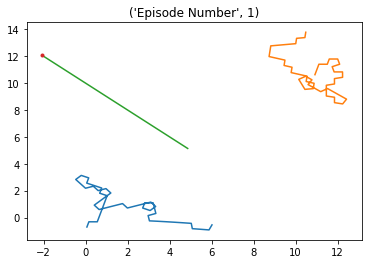

Current Episode: 2 Current Time Step: 0
Current Episode: 2 Current Time Step: 25
Episode * 2 * Avg Reward is ==> 108.02042246486656


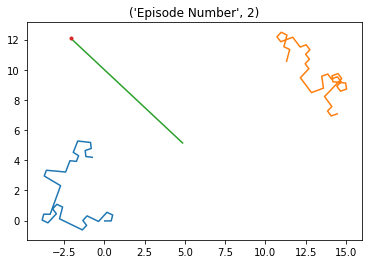

Current Episode: 3 Current Time Step: 0
Current Episode: 3 Current Time Step: 25
Episode * 3 * Avg Reward is ==> 110.0419659789505


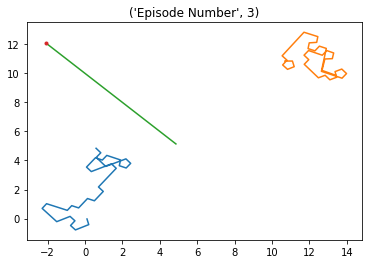

Current Episode: 4 Current Time Step: 0
Current Episode: 4 Current Time Step: 25
Episode * 4 * Avg Reward is ==> 106.21387558302669


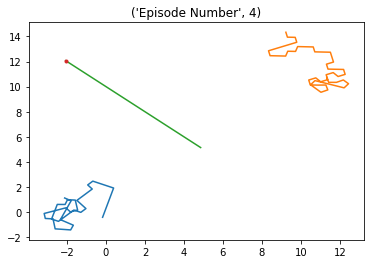

Current Episode: 5 Current Time Step: 0
Current Episode: 5 Current Time Step: 25
Episode * 5 * Avg Reward is ==> 106.11391709297357


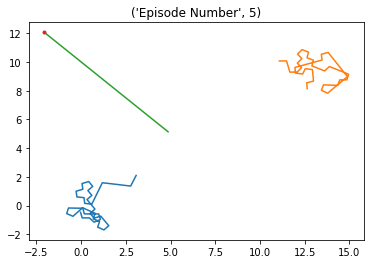

Current Episode: 6 Current Time Step: 0
Current Episode: 6 Current Time Step: 25
Episode * 6 * Avg Reward is ==> 104.07012796344975


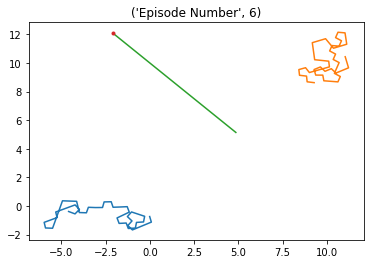

Current Episode: 7 Current Time Step: 0
Current Episode: 7 Current Time Step: 25
Episode * 7 * Avg Reward is ==> 101.43858989538833


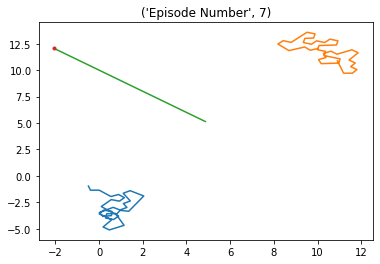

Current Episode: 8 Current Time Step: 0
Current Episode: 8 Current Time Step: 25
Episode * 8 * Avg Reward is ==> 99.42697071594645


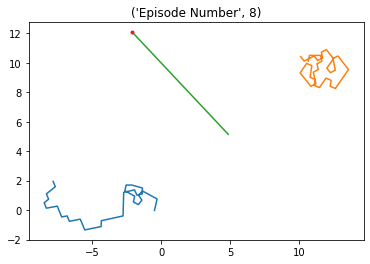

Current Episode: 9 Current Time Step: 0
Current Episode: 9 Current Time Step: 25
Episode * 9 * Avg Reward is ==> 99.92602682433638


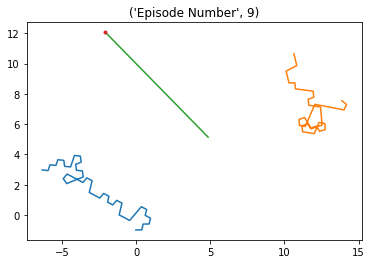

Current Episode: 10 Current Time Step: 0
Current Episode: 10 Current Time Step: 25
Episode * 10 * Avg Reward is ==> 99.3214398287353


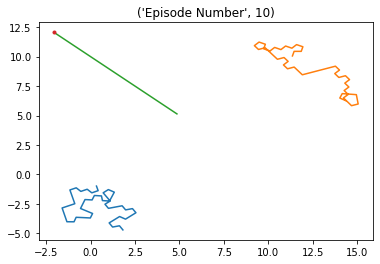

Current Episode: 11 Current Time Step: 0
Current Episode: 11 Current Time Step: 25
Episode * 11 * Avg Reward is ==> 96.51127311672367


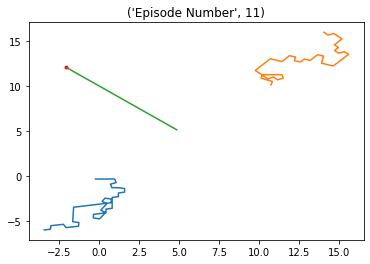

Current Episode: 12 Current Time Step: 0
Current Episode: 12 Current Time Step: 25
Episode * 12 * Avg Reward is ==> 98.55783512276082


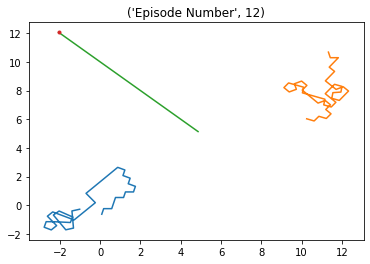

Current Episode: 13 Current Time Step: 0
Current Episode: 13 Current Time Step: 25
Episode * 13 * Avg Reward is ==> 99.09485695162236


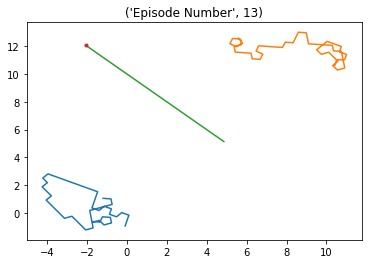

Current Episode: 14 Current Time Step: 0
Current Episode: 14 Current Time Step: 25
Episode * 14 * Avg Reward is ==> 99.17219396203298


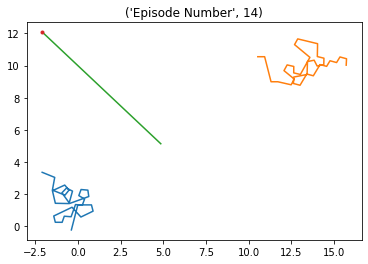

Current Episode: 15 Current Time Step: 0
Current Episode: 15 Current Time Step: 25
Episode * 15 * Avg Reward is ==> 99.05617485999184


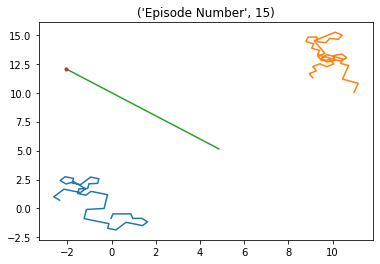

Current Episode: 16 Current Time Step: 0
Current Episode: 16 Current Time Step: 25
Episode * 16 * Avg Reward is ==> 99.0172836982235


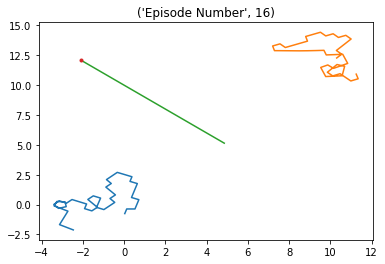

Current Episode: 17 Current Time Step: 0
Current Episode: 17 Current Time Step: 25
Episode * 17 * Avg Reward is ==> 98.18348732779624


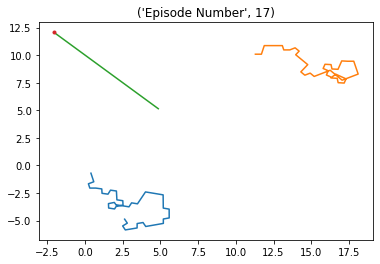

Current Episode: 18 Current Time Step: 0
Current Episode: 18 Current Time Step: 25
Episode * 18 * Avg Reward is ==> 100.88955041719929


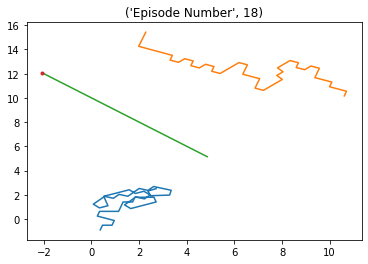

Current Episode: 19 Current Time Step: 0
Current Episode: 19 Current Time Step: 25
Episode * 19 * Avg Reward is ==> 98.44263057906674


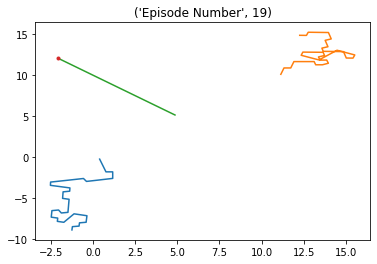

Current Episode: 20 Current Time Step: 0
Current Episode: 20 Current Time Step: 25
Episode * 20 * Avg Reward is ==> 97.73718876608677


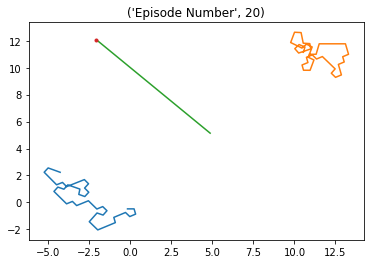

Current Episode: 21 Current Time Step: 0
Current Episode: 21 Current Time Step: 25
Episode * 21 * Avg Reward is ==> 97.79655354088943


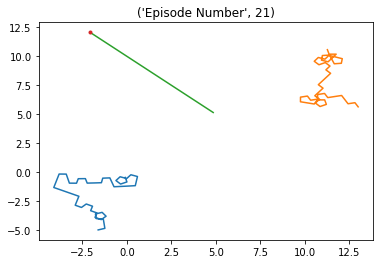

Current Episode: 22 Current Time Step: 0
Current Episode: 22 Current Time Step: 25
Episode * 22 * Avg Reward is ==> 97.34047060598256


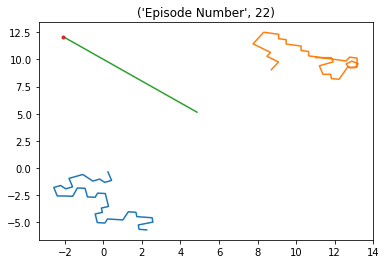

Current Episode: 23 Current Time Step: 0
Current Episode: 23 Current Time Step: 25
Episode * 23 * Avg Reward is ==> 97.6036361147922


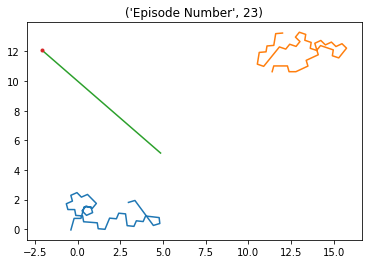

Current Episode: 24 Current Time Step: 0
Current Episode: 24 Current Time Step: 25
Episode * 24 * Avg Reward is ==> 100.13425848014005


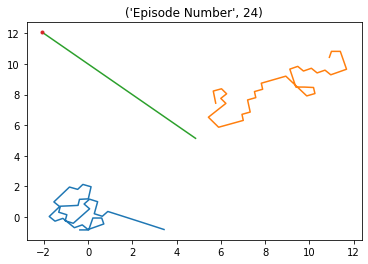

Current Episode: 25 Current Time Step: 0
Current Episode: 25 Current Time Step: 25
Episode * 25 * Avg Reward is ==> 101.6781429987843


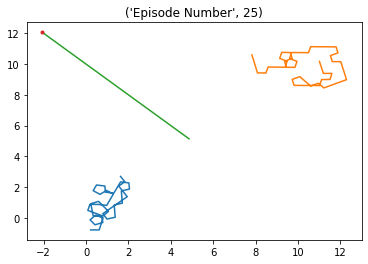

Current Episode: 26 Current Time Step: 0
Current Episode: 26 Current Time Step: 25
Episode * 26 * Avg Reward is ==> 101.03100760658205


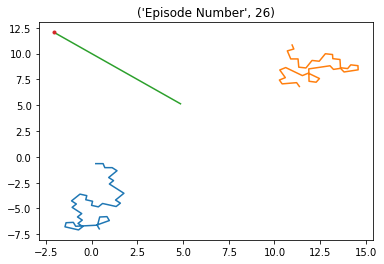

Current Episode: 27 Current Time Step: 0
Current Episode: 27 Current Time Step: 25
Episode * 27 * Avg Reward is ==> 100.34654934920862


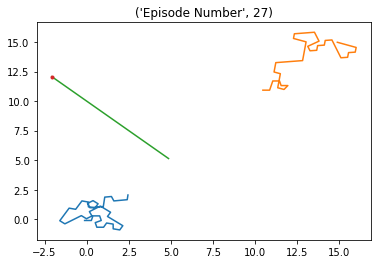

Current Episode: 28 Current Time Step: 0
Current Episode: 28 Current Time Step: 25
Episode * 28 * Avg Reward is ==> 102.34175668200689


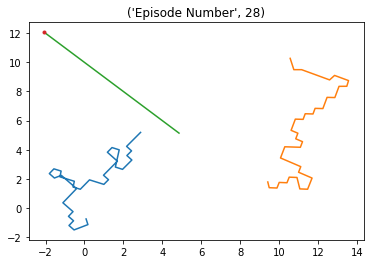

Current Episode: 29 Current Time Step: 0
Current Episode: 29 Current Time Step: 25
Episode * 29 * Avg Reward is ==> 105.70736078281912


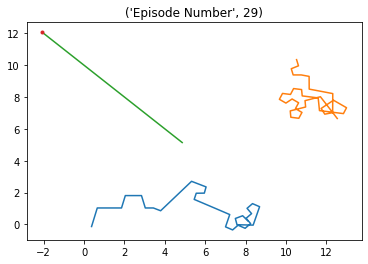

Current Episode: 30 Current Time Step: 0
Current Episode: 30 Current Time Step: 25
Episode * 30 * Avg Reward is ==> 104.33158792181368


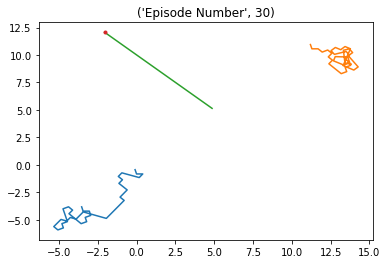

Current Episode: 31 Current Time Step: 0


KeyboardInterrupt: ignored

In [ ]:


ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []



# agent.load("./save/cartpole-dqn.h5")

batch_size = 32

#print(state_size, action_size)

for e in range(EPISODES):

    env = environment()
    prev_state = env.initial_obs()

    action_p1, action_p2, action_e = env.initial_actions()
    hot_encoded_actions = [action_p1, action_p2, action_e]


    episodic_reward = 0
    ag1_reward = 0
    
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []


    #prev_state = np.reshape(prev_state, [1, state_size])
    for time in range(50):
        # env.render()
        
        updated_actions = []

        for agent_number in range(num_agents):
            
            joint_prev_state = get_joint_action_state(prev_state, hot_encoded_actions,agent_number)
            
            joint_prev_state = np.reshape(joint_prev_state, [1, state_size])

            updated_actions.append(agents[i].act(joint_prev_state))


        #action = agent.act(prev_state)
        #print(action)

        next_state = env.step(updated_actions)
        #print(next_state)

        rew = reward(next_state)
        
        #next_state, reward, done, _ = env.step(action)
        #rew = rew #if not done else -10
        #print(next_state)

        updated_encoded_actions = encode_actions(updated_actions)

        #next_state = np.reshape(next_state, [1, state_size])

        
        
        for agent_number in range(num_agents-1):

            new_joint_action_state = get_joint_action_state(next_state,
                                                            updated_encoded_actions, agent_number)
            
            new_joint_action_state = np.reshape(new_joint_action_state, [1, state_size])
            
            agents[agent_number].memorize(joint_prev_state, updated_actions[agent_number],
                                          rew[agent_number], new_joint_action_state)
            
            if len(agents[agent_number].memory) > batch_size:
                agents[agent_number].replay(batch_size)

        prev_state = next_state
        #print(action)

        actions = updated_encoded_actions
        
        

        episodic_reward += sum(rew)
        #print(rew)
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)

        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)

        xce.append(env.e_rx)
        yce.append(env.e_ry)

        if time%25 ==0:
            print('Current Episode:', e+1, 'Current Time Step:', time)

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)

    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)

    print("Episode * {} * Avg Reward is ==> {}".format(e+1, avg_reward))

    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.')
    title = 'Episode Number', e+1
    plt.title(title)
    plt.show()



In [ ]:
a = np.array([1,2,3])

a[:2],a[3:]

In [ ]:
a = np.array([[1,2,3]])

b = [[0],[1],[2]]

np.hstack((a[0], b[1]))

array([1, 2, 3, 1])

In [ ]:
state = [1,2,3,4]

actions = [[0,1,0],[1,0,0],[0,0,1]]

js = get_joint_action_state(state, actions, 0)

js

array([1, 2, 3, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0])